In [1]:
import sys, os
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.ML.Cluster import Butina
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

In [2]:
LigandDescriptors = ['HeavyAtomCount','NHOHCount','NOCount']
DescCalc = MolecularDescriptorCalculator(LigandDescriptors)
len(LigandDescriptors)

3

In [3]:
def GetRDKitDescriptors(smile):
    '''Function for the calculation of ligand descriptors'''
    mol = Chem.MolFromSmiles(smile)
    mol.UpdatePropertyCache(strict=False)
    Chem.GetSymmSSSR(mol)
    return DescCalc.CalcDescriptors(mol)

def Update_descriptor(df):
    Features = []
    for i in df.canonical_smiles.tolist():
        Features.append(GetRDKitDescriptors(i))
    ss = pd.DataFrame(Features, columns=LigandDescriptors)
    df = pd.concat([df,ss], axis=1, ignore_index=False)
    df['LE'] = df['pchembl_value']/df['HeavyAtomCount']
    return df

### Combine all active compounds collected from ChEMBL 29 
#### (based on Uniprot_ids of CAMK2a, 2b, 2g and 2d)
1. The uniprot_id can be found at chembl_uniprot_mapping.txt;
2. The .csv data from ChEMBL 29 can be obtained using sqlit3 with command.txt

In [4]:
camk2a = pd.read_csv('dataset/dataset_chembl/chembl_Q9UQM7_CAMK2a.csv')
camk2b = pd.read_csv('dataset/dataset_chembl/chembl_Q13554_CAMK2b.csv')
camk2g = pd.read_csv('dataset/dataset_chembl/chembl_Q13555_CAMK2g.csv')
camk2d = pd.read_csv('dataset/dataset_chembl/chembl_Q13557_CAMK2d.csv')
df = pd.concat([camk2a,camk2b,camk2g,camk2d], ignore_index=True)
df = Update_descriptor(df)
df = df.sort_values(by='pchembl_value',ascending=False)
df.head(2)

,lig_chembl_id,pro_chembl_id,pref_name,accession,pchembl_value,standard_type,assay_id,confidence_score,canonical_smiles,description,HeavyAtomCount,NHOHCount,NOCount,LE
1275,CHEMBL388978,CHEMBL2801,CaM kinase II delta,Q13557,10.51,IC50,1828461,9,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,Inhibition of human CAMK2D using KKLNRTLSFAEPG...,35,2,7,0.300286
1262,CHEMBL4218769,CHEMBL2801,CaM kinase II delta,Q13557,10.30,IC50,1749582,9,CCN(CC)[C@@H](C)CNC(=O)c1cc(NC)nc(-c2cnn3ccc(-...,Inhibition of recombinant human full length Hi...,33,2,8,0.312121


#### Select compounds with confidence_socre >=8,
#### Then remove duplicates, and select compounds with pValue >=6 and LE >= 0.28.

In [5]:
len(df), len(df.loc[df['confidence_score']>=8])

(1332, 1108)

In [6]:
df1 = df.loc[df['confidence_score']>=8]
df1 = df1.drop_duplicates('lig_chembl_id')
df1 = df1.loc[(df1['pchembl_value']>=6)&(df1['LE']>=0.28)]
df1 = df1.sort_values(by='pchembl_value', ascending=False)
len(df1)

50

### Show compounds

In [10]:
mols = []
Name = []

for i,j,k in zip(df1['canonical_smiles'], df1['lig_chembl_id'], df1['pchembl_value']):
    mol = Chem.MolFromSmiles(i)
    mols.append(mol)
    Name.append('%s | pValue=%.2f'%(j,k))

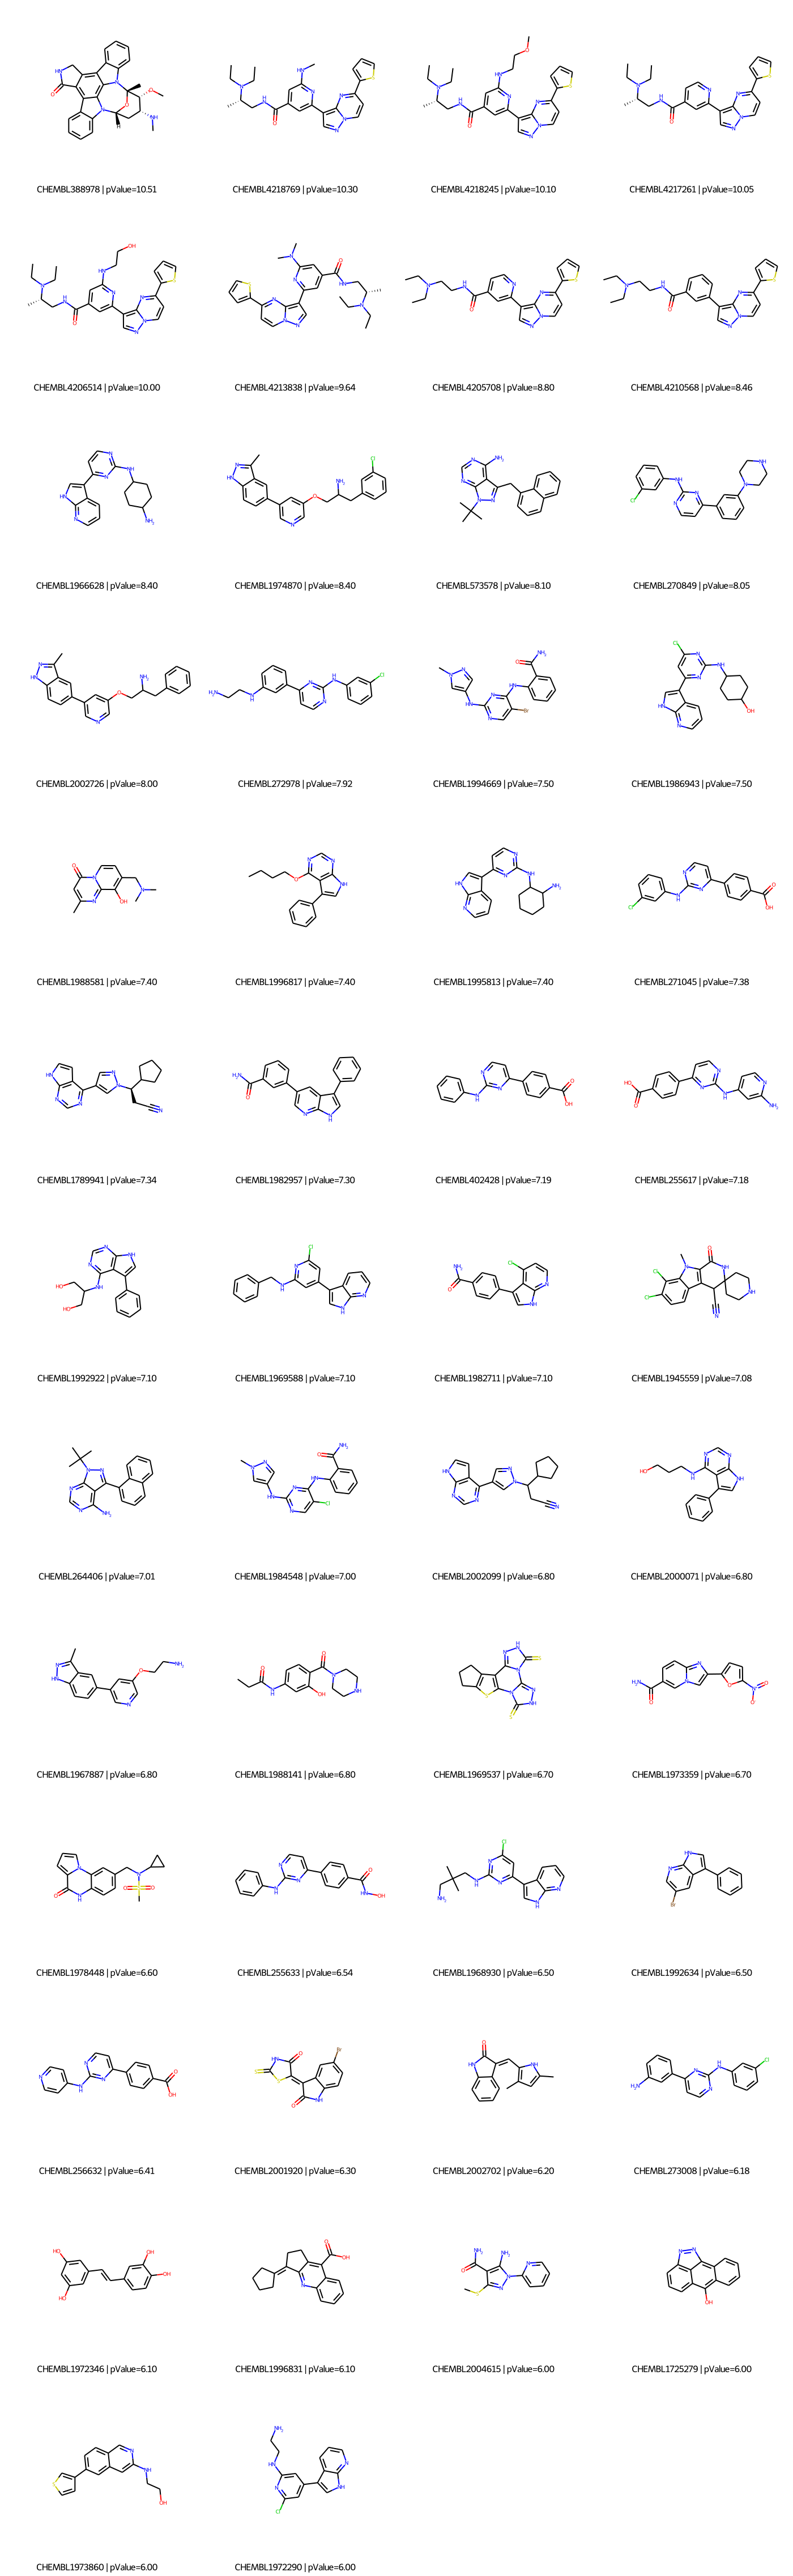

In [11]:
Chem.Draw.MolsToGridImage(mols,molsPerRow=4,subImgSize=(350, 350),legends=Name)

In [9]:
df1.to_csv('dataset/curated_binders/binders_from_chembl.csv', index=False)